# Introduction to PyCall

まず、PyCall について簡単に説明します。

PyCall の実態は「**Ruby から libpython.so を使うための拡張ライブラリ**」です。
PyCall は libpython.so の機能を利用して、Ruby から Python のオブジェクトを触れるようにするブリッジ機能を提供します。
PyCall を使うと、例えば以下のように Python 側の `sin` 関数を Ruby 側に持ってきて呼び出すことが可能です。

In [1]:
require 'pycall'

# PyCall.import_module function loads a module in Python, and brings the loaded module object in Ruby
pymath = PyCall.import_module('math')

<module 'math' from '/usr/local/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

In [2]:
# Accessing `sin` attribute of `math` module
pymath.sin

<built-in function sin>

In [3]:
# Calling function object by the syntax sugar of `.call` method call
pymath.sin.(Math::PI)

1.2246467991473532e-16

Ruby 側に持ってきた Python オブジェクトは、基本的なクラスを除いてすべて PyObject クラスのインスタンスによってラップされます。

In [4]:
# pymath is a module object in Python, but it is wrapped by an instance of PyObject in Ruby
pymath.class

PyCall::PyObject

In [5]:
# pymath.sin is a builtin-function object in Python, but it is wrapped by an instance of PyObject in Ruby
pymath.sin.class

PyCall::PyObject

In [6]:
# The result of pymath.sin is a float object in Python, but it is automatically converted to Float object in Ruby
pymath.sin.(Math::PI).class

Float

In [7]:
# The name of a function object
pymath.sin.__name__

"sin"

In [8]:
# It is converted to a String object in Ruby
pymath.sin.__name__.class

String

`pycall/import` が提供する機能を利用すると、Python での `import math` と同じような記法でモジュールをインポートできます。

やってみましょう

In [9]:
require 'pycall/import'
include PyCall::Import

pyimport :math

:math

In [10]:
math

<module 'math' from '/usr/local/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

In [11]:
math.sin

<built-in function sin>

In [12]:
math.sin.(Math::PI)

1.2246467991473532e-16

---
PyCall は PyObjectWrapper というモジュールを提供しています。このモジュールを使うと、Python のクラスに対応するラッパークラスを定義できます。ラッパークラスを定義すると、インスタンスメソッドやクラスメソッドの呼び出しを自然に記述できるようになります。

numpy を例に違いを見てみましょう。

まず、ラッパークラスを定義せずに numpy を使ってみます。

In [13]:
pyimport :numpy, as: :np

:np

In [14]:
np

<module 'numpy' from '/usr/local/lib/python3.6/site-packages/numpy/__init__.py'>

In [15]:
# `np.array` retrives a function object
np.array

<built-in function array>

In [16]:
# Use `.call` method to call `np.array`
ary = np.array.([*1..20].map { rand })

array([ 0.78720422,  0.04989502,  0.61287186,  0.58935543,  0.10911719,
        0.90534304,  0.17907297,  0.56424541,  0.7532547 ,  0.32246486,
        0.65825915,  0.70162822,  0.90634646,  0.19754435,  0.29295796,
        0.61622797,  0.14356238,  0.64854779,  0.18438799,  0.93683436])

In [17]:
# This is a PyObject
ary.class

PyCall::PyObject

In [18]:
# `ary.mean` retrieves a function object
ary.mean

<built-in method mean of numpy.ndarray object at 0x7f1dd411d8f0>

In [19]:
# Use `.call` method to call `ary.mean`
ary.mean.()

0.5079560660124105

次に、ラッパークラスを定義します。

In [20]:
module Numpy
  class NDArray
    include PyCall::PyObjectWrapper
    wrap_class PyCall.import_module('numpy').ndarray
  end
end

[#<struct PyCall::Conversions::TypePair pytype=#<PyCall::LibPython::PyObjectStruct:0x000000025816d0>, rbtype=Numpy::NDArray>]

これで Numpy::NDArray クラスが np.ndarray のラッパーになりました。

もう一度 ndarray オブジェクトを生成してみましょう。

In [21]:
ary2 = np.array.([*1..20].map { rand + 10 })

array([ 10.43929293,  10.774188  ,  10.69860716,  10.349782  ,
        10.40455471,  10.31237692,  10.42337371,  10.85054457,
        10.797475  ,  10.29543447,  10.97507191,  10.77216906,
        10.80617675,  10.90382459,  10.80300021,  10.61905881,
        10.67108304,  10.77988371,  10.91601262,  10.6303129 ])

In [22]:
# ary2 is a Numpy::NDArray!!
ary2.class

Numpy::NDArray

In [23]:
# ary2.mean calls mean method!!
ary2.mean

10.661111153255195

このように、PyObjectWrapper を利用して Python クラスのラッパーを Ruby 側に定義できました。
matplotlib のラッパーライブラリでは、この機能を使って Figure や Axes などのクラスのラッパーを定義しています。

残念ながら pandas の DataFrame ライブラリに対して wrap_class を適用するとエラーが出てしまう[問題があります](https://github.com/mrkn/pycall/issues/16)。
そのため、このチュートリアルでは pandas のラッパーを定義せずに使っていきます。

モジュールに対するラッパーを定義する機能はまだ作っていませんが、近日中に提供できる予定になっています。

# Data Analysis with Ruby using PyCall

それでは、PyCall を利用して Ruby でデータ分析をやってみましょう。

## 準備編

分析に入る前に、いくつか準備をします。

データの可視化のために seaborn ライブラリを利用します。このライブラリは matplotlib を利用しているため、IRuby と matplotlib の間の連携を有効にします。

In [24]:
require 'matplotlib/iruby'
Matplotlib::IRuby.activate

[:inline, "module://ruby.matplotlib.backend_inline"]

利用するライブラリをインポートしておきましょう。

In [25]:
pyimport :pandas, as: :pd
pyimport :seaborn, as: :sns

:sns

pandas のデータフレームを IRuby ノートブック上で見やすく表示するための準備をします。
これは、将来的には require 'pandas/iruby' などで自動的に実施されるようにする予定です。

In [26]:
module Pandas
  class DataFrame < PyCall::PyObject
  end
end

PyCall::Conversions.python_type_mapping(pd.DataFrame, Pandas::DataFrame)

dataframe_max_rows = 20

IRuby::Display::Registry.module_eval do
  type { Pandas::DataFrame }
  format "text/html" do |pyobj|
    pyobj.to_html.(max_rows: dataframe_max_rows, show_dimensions: true, notebook: true)
  end
end

## データ分析の実演

### データの準備と前処理

タイタニック号の乗客のデータを用いて、乗客の生存予測をするためのモデルを作ってみます。

seaborn ライブラリの `load_dataset` 関数を使ってデータのダウンロードと読み込みをします。

In [27]:
df = sns.load_dataset.('titanic')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


変数 `df` に代入されたオブジェクトは pandas のデータフレームです。

In [28]:
df.type

pytype(DataFrame)

---

データ解析の最初のステップは、データの内容を観察することから始まります。

上の表を見るとわかるように、このデータには、15個のカラムで構成されるレコードが890行あります。
これらのカラムのうち、以下のように内容が重複しているものがあります。

- `survived` は `alive` を `no` -> 0, `yes` -> 1 として変換して生成したもの
- `embarked` は `embark_town` の頭文字
- `pclass` は `class` を数値にしたもの
- `sex` と `who` は、`male` => `man`, `female` => `woman` という対応関係にある

内容が重複しているカラムが複数存在すると、情報量は変わらないのに処理量が増えてしまうため、これらを削除します。

In [29]:
df = df.drop.([:alive, :embark_town, :class, :who], axis: 1)
df.columns.values

array(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'adult_male', 'deck', 'alone'], dtype=object)

こうして残ったカラムは次のような意味を持っています。

| カラム名 | 意味 |
|:--- |:--- |
| `survived`   | 1: 生存, 0: 死亡 |
| `pclass`     | 乗客クラス (1: Upper, 2: Middle, 3: Lower) |
| `sex`        | 性別 (`male`: 男性, `female`: 女性) |
| `age`        | 年齢 (1歳未満は小数) |
| `sibsp`      | 同乗している兄弟・配偶者の人数 |
| `parch`      | 同乗している親・子供の人数 |
| `fare`       | チケット料金 |
| `embarked`   | 乗船した都市名の頭文字 |
| `adult_male` | 大人の男性の場合 true |
| `deck`       | 客室種別 |
| `alone`      | 一人で乗船の場合 true |

---

生のデータにはほぼ確実に欠損値が含まれています。このデータの場合はどうでしょうか？調べてみましょう。

データフレームの `isnull` メソッドを用いると、各行各列について欠損値の場合に `true`、そうで無い場合に `false` を対応させた同じ形のデータフレームが作られます。そのような欠損値フラグを集めたデータフレムに対して `sum` メソッドを適用することで、カラム別に欠損値の個数をカウントできます (`true` を 1, `false` を 0 として総和をとる)。

In [30]:
df.isnull.().sum.()

survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
embarked        2
adult_male      0
deck          688
alone           0
dtype: int64

これより、`age` カラムには177個の欠損値、`deck` カラムには688個の欠損値が存在し、その他のカラムには欠損値が無いことがわかりました。

全体で890行あるうち688個も値が欠損しているということは、`deck` カラムの値は分析には使えなさそうです。
今回は `deck` カラムは捨てることにします。

In [31]:
df = df.drop.(:deck, axis: 1)
nil

`age` カラムの分布を見てみましょう。

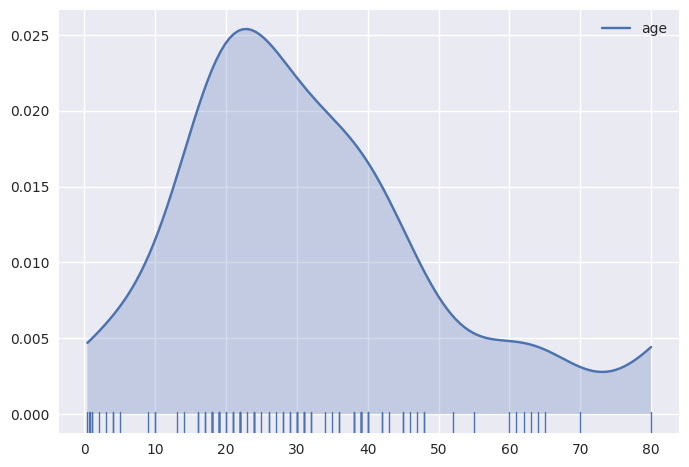

In [32]:
sampled_age = df[:age].dropna.().sample.(100) # 全てのデータを使うと少し時間がかかるのでランダムサンプリングする
sns.kdeplot.(sampled_age, shade: true, cut: 0)
sns.rugplot.(sampled_age)

あと、平均値も見てみます。せっかくなので全カラムの要約統計量を `describe` メソッドで求めましょう。

In [33]:
df.describe.()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


`age` の平均値は 29.699118、中央値は 28 であることが分かりました。

`age` の欠損値の位置を記録しておいて、ひとまず中央値を使って欠損値を埋めることにします。

In [34]:
age_isnull = df[:age].isnull.() # 欠損値の位置を記憶 (あとで使うかもしれないので)
nil

In [35]:
df[:age].fillna.(df[:age].median.(), inplace: true) # 欠損値を中央値で埋める
nil

もう一度欠損値の個数を求めてみましょう。

In [36]:
df.isnull.().sum.()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      2
adult_male    0
alone         0
dtype: int64

残るは `embarked` の2つですが、2件だけなので無視して進みます。

生存予測をするためのモデルを作るので、予測の対象となるカラムは `survived` です。
まず、各カラムが `survived` とどのくらい相関を持っているか見てみましょう。
そのためには、ラベルが入っている `sex` と `embarked` の2カラムの値を数値に変換する必要があります。

ラベル変数を数値変数へ変換したものをダミー変数と言い、pandas では `get_dummies` 関数を使って処理します。

In [37]:
sex_dummies = pd.get_dummies.(df[:sex])
embarked_dummies = pd.get_dummies.(df[:embarked])
df = pd.concat.(PyCall.tuple(df, sex_dummies, embarked_dummies), axis: 1)
df = df.drop.([:sex, :embarked, :S], axis: 1)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,female,male,C,Q
0,0,3,22.0,1,0,7.2500,True,False,0,1,0,0
1,1,1,38.0,1,0,71.2833,False,False,1,0,1,0
2,1,3,26.0,0,0,7.9250,False,True,1,0,0,0
3,1,1,35.0,1,0,53.1000,False,False,1,0,0,0
4,0,3,35.0,0,0,8.0500,True,True,0,1,0,0
5,0,3,28.0,0,0,8.4583,True,True,0,1,0,1
6,0,1,54.0,0,0,51.8625,True,True,0,1,0,0
7,0,3,2.0,3,1,21.0750,False,False,0,1,0,0
8,1,3,27.0,0,2,11.1333,False,False,1,0,0,0
9,1,2,14.0,1,0,30.0708,False,False,1,0,1,0


`sex` のダミー変数である `female` と `male`, および `embarked` のダミー変数である `C`, `Q` が追加されました。
元の `sex` と `embarked` は削除しました。

`embarked` のダミー変数にはもう一つ `S` が存在していますが、`C` と `Q` の両方が 0 の場合、(2件ある欠損値を除いて) `S` が 1 になっているはずです。ですから、`S` は情報量を持たないため削除しています。

これで、全てのカラムが数値データになったので、カラム間の相関係数を `corr` メソッドで求めます。

In [38]:
df.corr.()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,female,male,C,Q
survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.557080,-0.203367,0.543351,-0.543351,0.168240,0.003650
pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.094035,0.135207,-0.131900,0.131900,-0.243292,0.221009
age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,0.247704,0.171647,-0.081163,0.081163,0.030248,-0.031415
sibsp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.253586,-0.584471,0.114631,-0.114631,-0.059528,-0.026354
parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.349943,-0.583398,0.245489,-0.245489,-0.011069,-0.081228
fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.182024,-0.271832,0.182333,-0.182333,0.269335,-0.117216
adult_male,-0.557080,0.094035,0.247704,-0.253586,-0.349943,-0.182024,1.000000,0.404744,-0.908578,0.908578,-0.065980,-0.076789
alone,-0.203367,0.135207,0.171647,-0.584471,-0.583398,-0.271832,0.404744,1.000000,-0.303646,0.303646,-0.095298,0.086464
female,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,-0.908578,-0.303646,1.000000,-1.000000,0.082853,0.074115
male,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,0.908578,0.303646,-1.000000,1.000000,-0.082853,-0.074115


性別系のカラム (`female`, `male`, `adult_male`) が最も相関が高いことがわかります。

---

### モデリング

ここでは、ランダムフォレスト ( `sklearn.ensemble.RandomForestClassifier` )、ロジスティック回帰 ( `sklearn.linear_model.LogisticRegression` )、サポートベクトルマシン ( `sklearn.svm.SVC` ) の3種類のモデルを作り、それぞれの精度を比較します。
モデルのハイパーパラメータをグリッドサーチ ( `sklearn.model_selection.GridSearchCV` ) で最適化します。

In [39]:
pyfrom 'sklearn.ensemble', import: :RandomForestClassifier
pyfrom 'sklearn.linear_model', import: :LogisticRegression
pyfrom 'sklearn.svm', import: :SVC
pyfrom 'sklearn.model_selection', import: :GridSearchCV

pytype(GridSearchCV)

#### ランダムフォレストによる分類モデルの作成

In [40]:
rfc = GridSearchCV.(
  RandomForestClassifier.(n_jobs: 2),
  {
    n_estimators: [10, 20, 50],
    max_depth: [4, 5, 6, 7],
    max_features: [:auto, :log2, PyCall.None],
  },
  scoring: :roc_auc,
  n_jobs: 4,
  cv: 5
)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 50], 'max_depth': [4, 5, 6, 7], 'max_features': ['auto', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [41]:
x_names = [:pclass, :age, :sibsp, :parch, :fare, :adult_male, :alone, :female, :male, :C, :Q]
x = df[x_names]
y = df[:survived]
rfc.fit.(x, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 50], 'max_depth': [4, 5, 6, 7], 'max_features': ['auto', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [42]:
rfc.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 20}

In [43]:
rfc.best_score_

0.8764839649977957

グリッドサーチおよび交差検定の結果は `cv_results_` 属性に入っています。この属性の値は、そのまま pandas の DataFrame に渡せます。

In [44]:
pd.DataFrame.(data: rfc.cv_results_).drop.(:params, axis: 1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.135095,0.105550,0.863078,0.893600,4,auto,10,34,0.857510,0.893122,0.827273,0.907941,0.862099,0.888021,0.867513,0.890415,0.901444,0.888500,0.012107,0.000627,0.023671,0.007392
1,0.125255,0.103405,0.858664,0.895714,4,auto,20,36,0.854414,0.900206,0.820092,0.902451,0.870053,0.891721,0.846858,0.895167,0.902388,0.889026,0.006131,0.000456,0.027130,0.005031
2,0.182410,0.104324,0.866282,0.896997,4,auto,50,25,0.856061,0.900569,0.829710,0.907540,0.872928,0.894871,0.870254,0.896858,0.902928,0.885144,0.012350,0.001152,0.023842,0.007334
3,0.132539,0.104010,0.864671,0.891364,4,log2,10,31,0.862516,0.889626,0.825033,0.902718,0.866511,0.888491,0.874198,0.896073,0.895507,0.879915,0.011379,0.000705,0.022897,0.007661
4,0.152971,0.104265,0.864805,0.895517,4,log2,20,30,0.863900,0.898929,0.832279,0.901862,0.863837,0.889023,0.865307,0.902270,0.899083,0.885501,0.024055,0.000832,0.021127,0.006928
5,0.152543,0.103466,0.865151,0.896761,4,log2,50,29,0.853821,0.897198,0.836693,0.906193,0.871524,0.892988,0.863102,0.899436,0.901039,0.887989,0.006887,0.000839,0.021291,0.006123
6,0.114902,0.102968,0.868485,0.915455,4,None,10,21,0.853294,0.923227,0.832477,0.925860,0.877540,0.912467,0.858289,0.911706,0.921411,0.904015,0.003708,0.000234,0.030008,0.008032
7,0.124346,0.104010,0.865744,0.920027,4,None,20,27,0.840711,0.924174,0.817457,0.931454,0.882955,0.915913,0.867781,0.915767,0.920534,0.912828,0.004802,0.002074,0.035365,0.006851
8,0.155140,0.103040,0.865841,0.920221,4,None,50,26,0.837813,0.925367,0.813373,0.932243,0.890842,0.917293,0.880348,0.920427,0.907515,0.905777,0.010909,0.000223,0.034968,0.008812
9,0.115044,0.103578,0.873432,0.912243,5,auto,10,6,0.871344,0.926394,0.838867,0.917136,0.876805,0.908015,0.864171,0.911332,0.916419,0.898337,0.001589,0.000983,0.025048,0.009341


もっとも成績が良かったランダムフォレストモデルにおける特徴量の重要度を見てみましょう。

もっとも成績が良いモデルは `best_estimator_` で取得できます。
このモデルは RandomForestClassifier のインスタンスなので、`feature_importances_` 属性を持っています。
これと `x_names` を seaborn の barplot を使って可視化します。

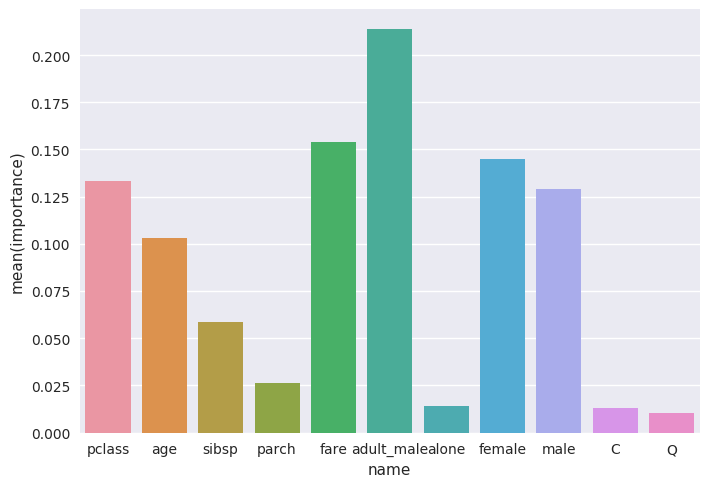

In [45]:
df_importance = pd.DataFrame.(data: {
  name: x_names,
  importance: rfc.best_estimator_.feature_importances_
})
sns.barplot.(x: :name, y: :importance, data: df_importance)

`adult_male` や性別 (`female`, `male`) が大きく寄与していることがわかります。
逆に `alone`、`C`、`Q` はほとんど寄与していません。

もう一度、カラム間の相関行列を見てみましょう。

In [46]:
df.corr.()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,female,male,C,Q
survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.557080,-0.203367,0.543351,-0.543351,0.168240,0.003650
pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.094035,0.135207,-0.131900,0.131900,-0.243292,0.221009
age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,0.247704,0.171647,-0.081163,0.081163,0.030248,-0.031415
sibsp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.253586,-0.584471,0.114631,-0.114631,-0.059528,-0.026354
parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.349943,-0.583398,0.245489,-0.245489,-0.011069,-0.081228
fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.182024,-0.271832,0.182333,-0.182333,0.269335,-0.117216
adult_male,-0.557080,0.094035,0.247704,-0.253586,-0.349943,-0.182024,1.000000,0.404744,-0.908578,0.908578,-0.065980,-0.076789
alone,-0.203367,0.135207,0.171647,-0.584471,-0.583398,-0.271832,0.404744,1.000000,-0.303646,0.303646,-0.095298,0.086464
female,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,-0.908578,-0.303646,1.000000,-1.000000,0.082853,0.074115
male,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,0.908578,0.303646,-1.000000,1.000000,-0.082853,-0.074115


`adult_male`, `female`, `male`, はどれも0.5を超える相関係数を持っていて、かつ、特徴量としての重要度も高くなっていました。
しかし、`fare` と `alone` を見てみると、これらは同程度の相関係数になっていますが、特徴量としての重要度は `fare` は `female` と同じくらい高いのに対し、`alone` はもっとも重要度が低い特徴量でした。
このように、単に相関係数を見るだけでは、特徴量が分類にどの程度重要になるかは分からないのです。

#### ロジスティク回帰による分類モデルの作成

In [47]:
lrc = GridSearchCV.(
  LogisticRegression.(n_jobs: 2),
  {
    penalty: [:l2, :l1],
    C: [10.0, 1.0, 0.1, 0.01],
  },
  scoring: :roc_auc,
  n_jobs: 4,
  cv: 5
)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=2,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'penalty': ['l2', 'l1'], 'C': [10.0, 1.0, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [48]:
lrc.fit.(x, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=2,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'penalty': ['l2', 'l1'], 'C': [10.0, 1.0, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [49]:
lrc.best_params_

{'C': 10.0, 'penalty': 'l1'}

In [50]:
pd.DataFrame.(data: lrc.cv_results_).drop.(:params, axis: 1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.019578,0.002549,0.861875,0.870107,10,l2,2,0.851647,0.873222,0.839262,0.875963,0.867447,0.869257,0.854479,0.871303,0.896924,0.860791,0.003053,0.000502,0.019619,0.005156
1,0.057700,0.001965,0.861902,0.870074,10,l1,1,0.852701,0.873080,0.838472,0.876004,0.867848,0.869216,0.853543,0.871253,0.897329,0.860816,0.030385,0.000329,0.019941,0.005139
2,0.007003,0.001180,0.861099,0.869869,1,l2,4,0.852569,0.871678,0.838472,0.877331,0.865575,0.868343,0.854479,0.870737,0.894765,0.861256,0.001367,0.000282,0.018852,0.005220
3,0.019780,0.001720,0.861548,0.870184,1,l1,3,0.854150,0.872579,0.840053,0.876972,0.865709,0.868526,0.851939,0.871685,0.896249,0.861156,0.005793,0.000564,0.019103,0.005260
4,0.008617,0.001869,0.854299,0.863025,0.1,l2,5,0.843742,0.862508,0.838076,0.868503,0.849131,0.863521,0.854746,0.866447,0.886131,0.854147,0.001068,0.000648,0.016791,0.004920
5,0.006309,0.001280,0.850051,0.858238,0.1,l1,6,0.850725,0.855441,0.835705,0.861778,0.842848,0.859580,0.844385,0.862124,0.876821,0.852264,0.001306,0.000357,0.014163,0.003820
6,0.008014,0.001878,0.841188,0.851557,0.01,l2,7,0.813570,0.851761,0.837022,0.855086,0.829345,0.851915,0.842179,0.853162,0.884242,0.845861,0.001652,0.000428,0.023519,0.003087
7,0.005691,0.001634,0.668766,0.678327,0.01,l1,8,0.569960,0.714090,0.730040,0.674669,0.643115,0.684552,0.696056,0.661370,0.705073,0.656955,0.001606,0.000693,0.057076,0.020374


#### サポートベクトルマシンによる分類モデルの作成

In [51]:
svc = GridSearchCV.(
  SVC.(kernel: :rbf),
  {
    C: [10.0, 1.0, 0.1, 0.01],
    gamma: [5, 10, 15, 20].map {|x| 1.0 / x },
  },
  scoring: :roc_auc,
  n_jobs: 4,
  cv: 5
)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': [10.0, 1.0, 0.1, 0.01], 'gamma': [0.2, 0.1, 0.06666666666666667, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [52]:
svc.fit.(x, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': [10.0, 1.0, 0.1, 0.01], 'gamma': [0.2, 0.1, 0.06666666666666667, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [53]:
svc.best_params_

{'C': 1.0, 'gamma': 0.05}

In [54]:
svc.best_score_

0.7861745269974777

In [55]:
pd.DataFrame.(data: svc.cv_results_).drop.(:params, axis: 1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.079361,0.008525,0.764278,0.973148,10,0.2,7,0.706588,0.977446,0.739789,0.973087,0.792179,0.978713,0.796190,0.967224,0.787237,0.969268,0.018322,0.001247,0.035395,0.004463
1,0.042405,0.005943,0.764156,0.969342,10,0.1,8,0.698419,0.975460,0.741634,0.969866,0.786832,0.975754,0.807821,0.964347,0.786697,0.961281,0.007624,0.001010,0.039429,0.005809
2,0.038538,0.004008,0.770427,0.964944,10,0.0666667,6,0.731884,0.966557,0.740975,0.965961,0.777072,0.967174,0.814906,0.962710,0.787777,0.962318,0.004063,0.000151,0.030603,0.002025
3,0.032319,0.004181,0.771351,0.957600,10,0.05,5,0.722793,0.957905,0.746113,0.959169,0.769184,0.961754,0.819452,0.956699,0.799784,0.952472,0.003546,0.000336,0.035006,0.003063
4,0.024443,0.005262,0.776894,0.956813,1,0.2,3,0.722661,0.957220,0.741502,0.959978,0.784158,0.962236,0.827340,0.952409,0.809498,0.952223,0.000846,0.000805,0.039656,0.004001
5,0.024468,0.004256,0.775444,0.941323,1,0.1,4,0.697497,0.945380,0.735968,0.945518,0.786430,0.948410,0.825735,0.934884,0.832569,0.932424,0.002496,0.000093,0.052070,0.006402
6,0.023904,0.004472,0.781821,0.927249,1,0.0666667,2,0.700000,0.928359,0.742029,0.933845,0.787099,0.935283,0.835094,0.923703,0.845926,0.915055,0.001110,0.000268,0.055244,0.007356
7,0.023374,0.004606,0.786175,0.918397,1,0.05,1,0.708827,0.924145,0.747694,0.929439,0.795789,0.925548,0.833623,0.907699,0.845926,0.905151,0.001236,0.000641,0.051738,0.009960
8,0.026061,0.007847,0.762136,0.933353,0.1,0.2,9,0.697760,0.932472,0.715810,0.935155,0.769987,0.942865,0.820120,0.932241,0.807879,0.924030,0.003982,0.004482,0.048615,0.006044
9,0.023314,0.008007,0.756844,0.909156,0.1,0.1,16,0.640053,0.902968,0.714229,0.915914,0.769452,0.915688,0.820922,0.905205,0.840934,0.906005,0.000844,0.004808,0.073225,0.005517


#### 結果

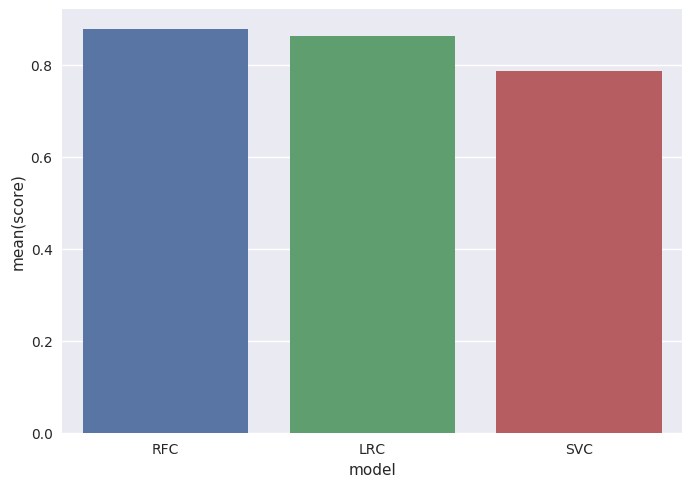

In [56]:
result = pd.DataFrame.(data: {
  model: %w[RFC LRC SVC],
  score: [rfc.best_score_, lrc.best_score_, svc.best_score_]
})
sns.barplot.(x: :model, y: :score, data: result)